# Enhancing NHL Salary Evaluation through Dimensionality Reduction  
Raphaël Fontaine  
McGill University  
Montreal, Canada  
raphael.fontaine@mail.mcgill.ca  

# Random Projection

In [5]:
import common
import pandas as pd
import numpy as np
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

In [6]:
df = common.load_dataset()

# Split features and label
X_data, y_data = common.split_dataset(df)

X_columns = X_data.columns

# Split train and test data
X_train, y_train, X_test, y_test = common.split_train_test(X_data, y_data)

# Standardize the features
X_train, X_test = common.standard_scaler(X_train, X_test)

## Johnson-Lindenstrauss Lemma

In [7]:
X = X_train.copy()
n_samples, n_features = X.shape

# Determine the minimum of components k for different values of epsilon, using the Johnson-Lindenstrauss Lemma
epsilons = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

n_components = []

for eps in epsilons:
    denominator = (eps**2 / 2) - (eps**3 / 3)
    k = (4 * np.log(n_samples) / denominator).astype(np.int64)
    n_components.append(k)

# Print results as a table
jl_df = pd.DataFrame(data={'Epsilon': epsilons, 'Number of components': n_components})
display(jl_df)

# Discard the number of components that are bigger than the dataset dimension
jl_df = jl_df[jl_df['Number of components'] < n_features]

,Epsilon,Number of components
0,0.1,7014
1,0.2,1888
2,0.3,909
3,0.4,557
4,0.5,392
5,0.6,303
6,0.7,250
7,0.8,219
8,0.9,202


## Gaussian Random Matrix Projection

In [8]:
results = []
for eps, n_component in jl_df.to_numpy():
    n_component = int(n_component)

    # Generate a dense Gaussian random matrix
    rng = np.random.default_rng(12345)
    scale = 1.0 / np.sqrt(n_component)
    random_matrix = rng.normal(size=(n_features, n_component), scale=scale).astype(X.dtype, copy=False)

    # Project data onto random matrix
    X_train_projected = np.dot(X, random_matrix)
    X_test_projected = np.dot(X_test, random_matrix)

    # Train and evaluate the models
    results_df, predictions = common.train_and_evaluate(X_train_projected, y_train, X_test_projected, y_test)

    results_df["Components"] = n_component
    results_df["Epsilon"] = eps

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Epsilon")[results_df.columns].apply(lambda x: x).drop(columns=["Epsilon"])

R2        MAE Top-100 MAE Top-50 MAE   SMAPE  \
Epsilon Model                                                                   
0.4     Linear Regression    0.4772  1,449,343   1,925,584  2,289,866  0.3670   
        Random Forest        0.5501  1,387,369   1,910,571  2,486,037  0.3543   
        Support Vector       0.5802  1,293,677   1,951,716  2,504,092  0.3250   
        K-Nearest Neighbors  0.5446  1,379,937   2,002,477  2,584,236  0.3501   
0.5     Linear Regression    0.5293  1,386,897   1,747,167  2,142,316  0.3507   
        Random Forest        0.5646  1,354,649   1,820,897  2,384,940  0.3478   
        Support Vector       0.5878  1,280,588   1,922,684  2,503,436  0.3236   
        K-Nearest Neighbors  0.5535  1,356,066   2,031,758  2,652,892  0.3430   
0.6     Linear Regression    0.5306  1,391,917   1,859,150  2,263,253  0.3539   
        Random Forest        0.5576  1,366,545   1,813,436  2,367,626  0.3494   
        Support Vector       0.5797  1,302,989   1,832,474  2,350,518  0.3306   
        K-Nearest Neighbors  0.5715  1,331,155   1,966,218  2,541,004  0.3387   
0.7     Linear Regression    0.5420  1,373,855   1,979,209  2,385,997  0.3465   
        Random Forest        0.5602  1,364,271   1,871,017  2,422,313  0.3501   
        Support Vector       0.5668  1,324,016   1,950,564  2,453,819  0.3337   
        K-Nearest Neighbors  0.5695  1,345,593   1,941,830  2,438,948  0.3443   
0.8     Linear Regression    0.5706  1,333,041   1,919,475  2,339,018  0.3348   
        Random Forest        0.5543  1,371,156   1,856,456  2,405,458  0.3515   
        Support Vector       0.5898  1,272,156   1,907,310  2,430,132  0.3195   
        K-Nearest Neighbors  0.5424  1,382,793   2,073,160  2,689,819  0.3519   
0.9     Linear Regression    0.5653  1,336,946   1,828,793  2,223,758  0.3405   
        Random Forest        0.5542  1,386,972   1,834,528  2,384,162  0.3564   
        Support Vector       0.5798  1,291,950   1,853,697  2,358,625  0.3265   
        K-Nearest Neighbors  0.5564  1,370,809   2,025,079  2,562,036  0.3488   

                             Train time (sec)  Components  
Epsilon Model                                              
0.4     Linear Regression                6.60         557  
        Random Forest                   12.13         557  
        Support Vector                   5.85         557  
        K-Nearest Neighbors              0.00         557  
0.5     Linear Regression                5.15         392  
        Random Forest                   11.47         392  
        Support Vector                   3.47         392  
        K-Nearest Neighbors              0.03         392  
0.6     Linear Regression                3.60         303  
        Random Forest                   10.39         303  
        Support Vector                   2.50         303  
        K-Nearest Neighbors              0.00         303  
0.7     Linear Regression                2.88         250  
        Random Forest                   10.73         250  
        Support Vector                   2.21         250  
        K-Nearest Neighbors              0.00         250  
0.8     Linear Regression                2.86         219  
        Random Forest                   12.10         219  
        Support Vector                   2.12         219  
        K-Nearest Neighbors              0.00         219  
0.9     Linear Regression                3.75         202  
        Random Forest                    7.88         202  
        Support Vector                   1.36         202  
        K-Nearest Neighbors              0.00         202

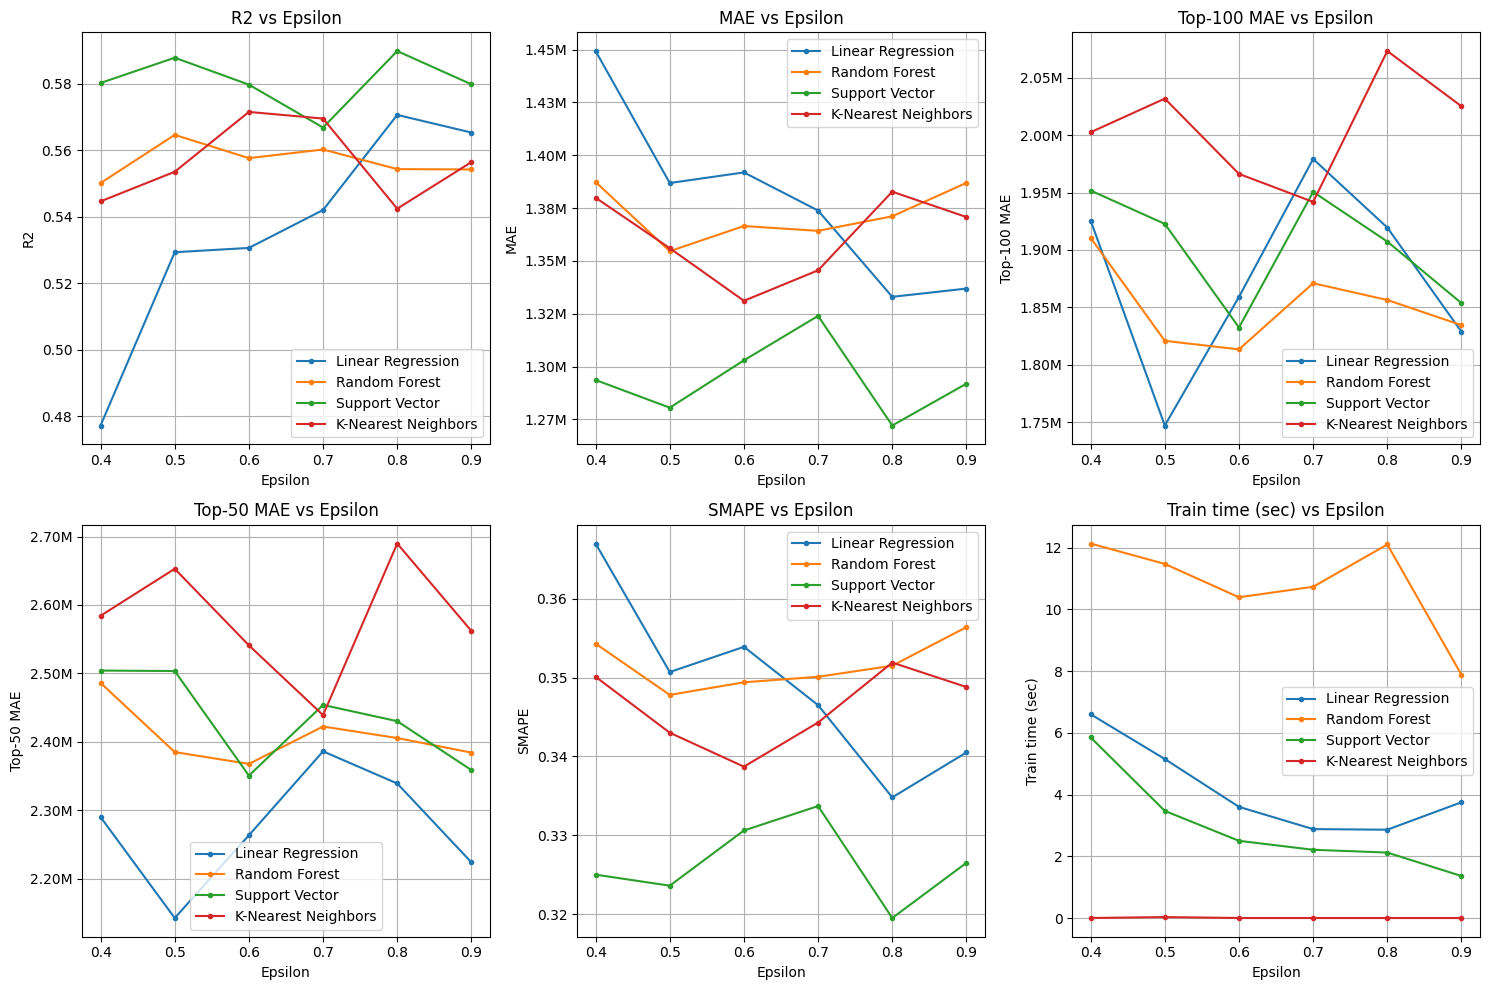

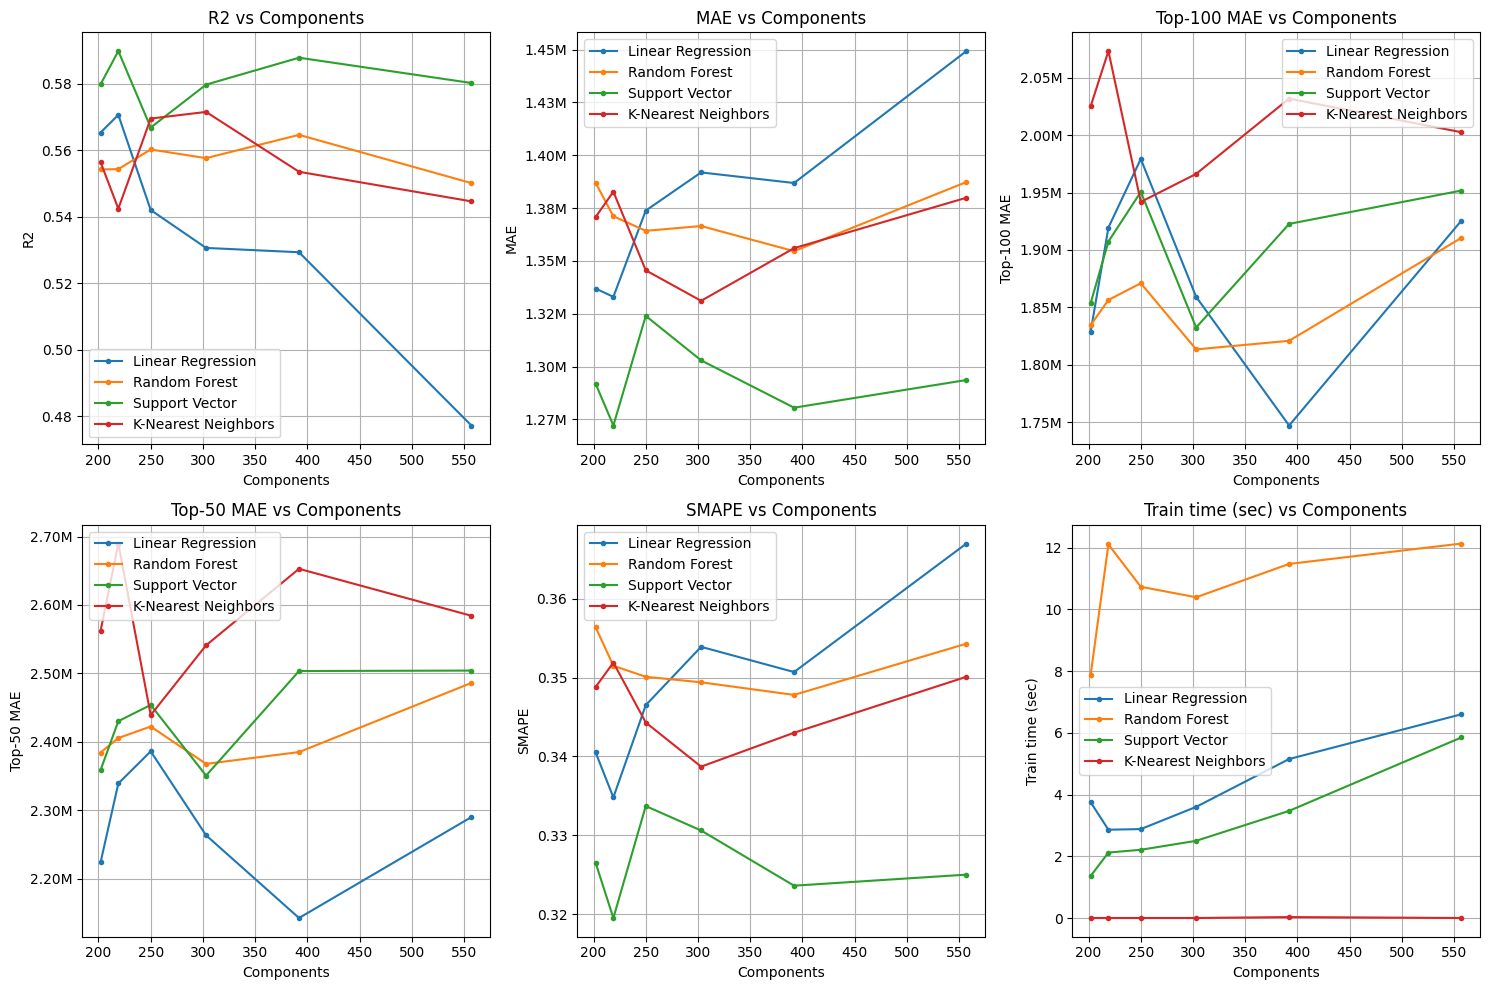

In [9]:
common.plot_metrics(results_df, "Epsilon")
common.plot_metrics(results_df, "Components")

## Sparse Random Matrix Projection

In [10]:
# Density of sparse matrices
p = 1 / np.sqrt(n_features)

results = []
for eps, n_component in jl_df.to_numpy():
    n_component = int(n_component)

    # Generate random sparse matrix
    rng = np.random.default_rng(12345)
    k = n_component

    random_matrix = rng.choice(
        [-np.sqrt(1/(k*p)), 0, np.sqrt(1/(k*p))], 
        size=(n_features, n_component),
        p=[p/2, 1-p, p/2]
    ).astype(X.dtype, copy=False)

    # Project data onto random sparse matrix
    X_train_projected = np.dot(X, random_matrix)
    X_test_projected = np.dot(X_test, random_matrix)

    # Train and evaluate the models
    results_df, predictions = common.train_and_evaluate(X_train_projected, y_train, X_test_projected, y_test)

    results_df["Components"] = n_component
    results_df["Epsilon"] = eps

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Epsilon")[results_df.columns].apply(lambda x: x).drop(columns=["Epsilon"])

R2        MAE Top-100 MAE Top-50 MAE   SMAPE  \
Epsilon Model                                                                   
0.4     Linear Regression    0.4929  1,447,730   1,926,613  2,277,496  0.3659   
        Random Forest        0.5677  1,354,581   1,834,340  2,360,674  0.3479   
        Support Vector       0.5896  1,293,912   1,809,285  2,348,889  0.3277   
        K-Nearest Neighbors  0.5631  1,342,076   1,981,836  2,564,548  0.3414   
0.5     Linear Regression    0.5196  1,408,368   1,835,555  2,246,959  0.3554   
        Random Forest        0.5720  1,337,485   1,853,278  2,385,929  0.3439   
        Support Vector       0.5779  1,300,279   1,975,796  2,534,010  0.3272   
        K-Nearest Neighbors  0.5470  1,361,326   2,094,948  2,639,123  0.3453   
0.6     Linear Regression    0.5443  1,370,806   1,880,034  2,328,615  0.3467   
        Random Forest        0.5562  1,369,647   1,860,205  2,429,080  0.3509   
        Support Vector       0.5690  1,309,732   2,001,370  2,588,757  0.3325   
        K-Nearest Neighbors  0.5603  1,348,553   1,981,113  2,578,589  0.3418   
0.7     Linear Regression    0.5335  1,376,338   1,971,659  2,483,549  0.3466   
        Random Forest        0.5628  1,373,886   1,824,280  2,345,156  0.3520   
        Support Vector       0.5630  1,322,790   1,996,544  2,565,925  0.3328   
        K-Nearest Neighbors  0.5500  1,367,573   1,973,876  2,481,862  0.3477   
0.8     Linear Regression    0.5554  1,380,573   1,930,908  2,388,718  0.3494   
        Random Forest        0.5532  1,371,430   1,874,032  2,438,786  0.3530   
        Support Vector       0.5586  1,339,521   1,954,430  2,506,329  0.3392   
        K-Nearest Neighbors  0.5477  1,351,692   1,991,498  2,576,106  0.3443   
0.9     Linear Regression    0.5807  1,320,126   1,937,740  2,362,910  0.3382   
        Random Forest        0.5614  1,364,272   1,904,327  2,451,333  0.3507   
        Support Vector       0.5757  1,290,071   1,986,179  2,523,237  0.3235   
        K-Nearest Neighbors  0.5380  1,373,240   2,162,742  2,707,002  0.3471   

                             Train time (sec)  Components  
Epsilon Model                                              
0.4     Linear Regression                3.99         557  
        Random Forest                   12.45         557  
        Support Vector                   3.51         557  
        K-Nearest Neighbors              0.00         557  
0.5     Linear Regression                2.70         392  
        Random Forest                    7.19         392  
        Support Vector                   1.94         392  
        K-Nearest Neighbors              0.00         392  
0.6     Linear Regression                0.14         303  
        Random Forest                    6.44         303  
        Support Vector                   1.64         303  
        K-Nearest Neighbors              0.00         303  
0.7     Linear Regression                0.12         250  
        Random Forest                    5.45         250  
        Support Vector                   1.19         250  
        K-Nearest Neighbors              0.00         250  
0.8     Linear Regression                0.12         219  
        Random Forest                    5.19         219  
        Support Vector                   1.09         219  
        K-Nearest Neighbors              0.00         219  
0.9     Linear Regression                0.11         202  
        Random Forest                    5.52         202  
        Support Vector                   1.06         202  
        K-Nearest Neighbors              0.02         202

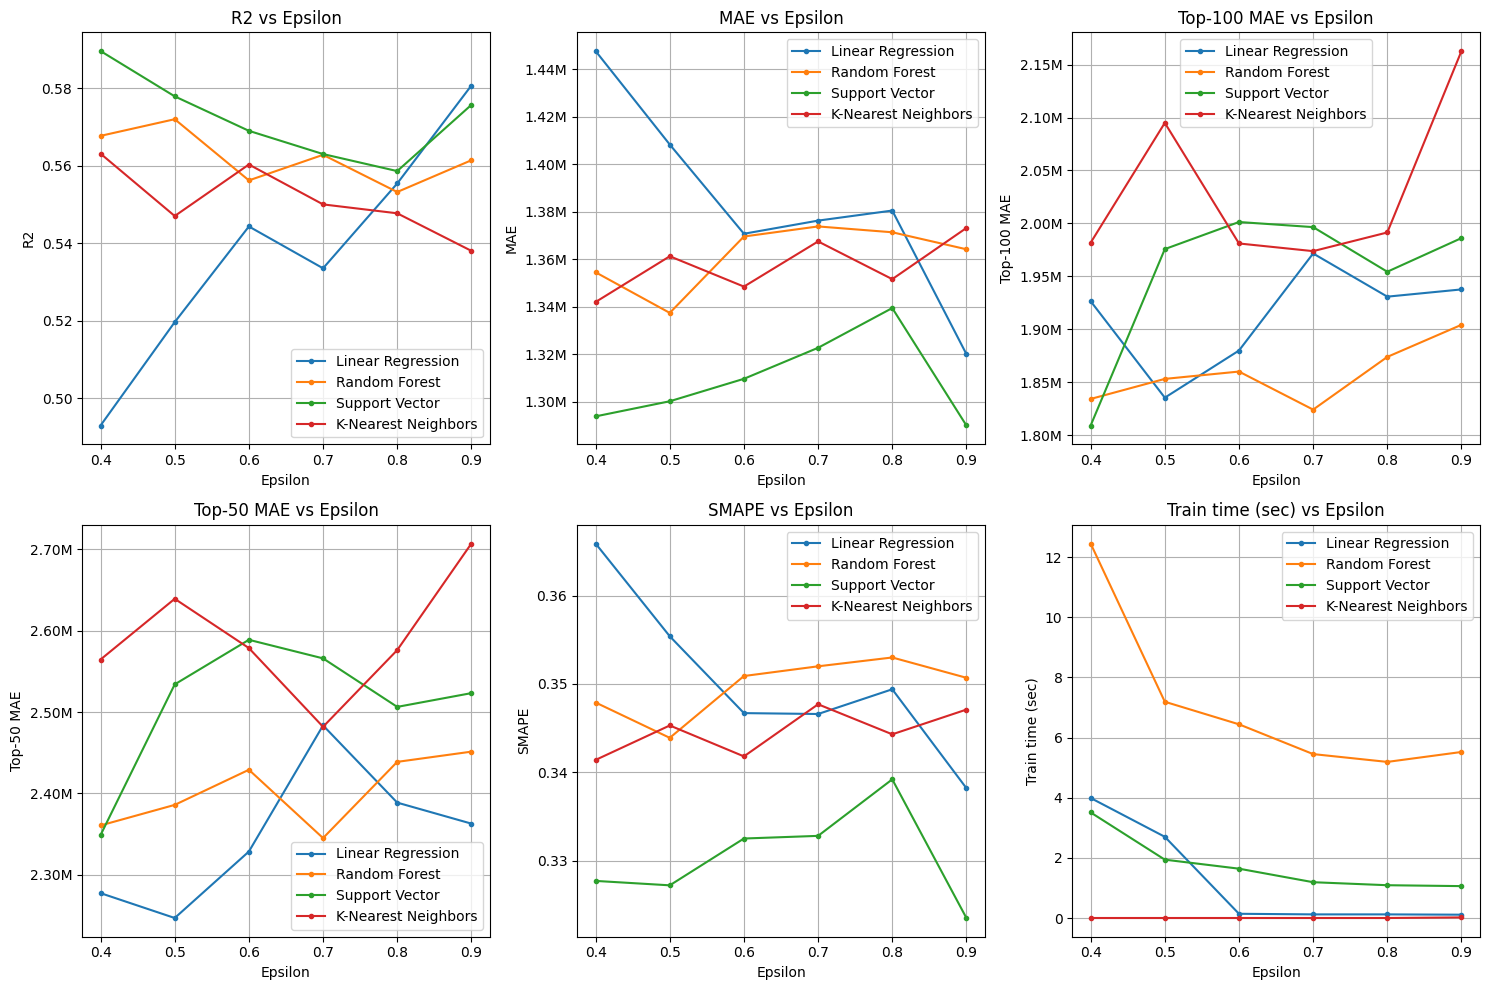

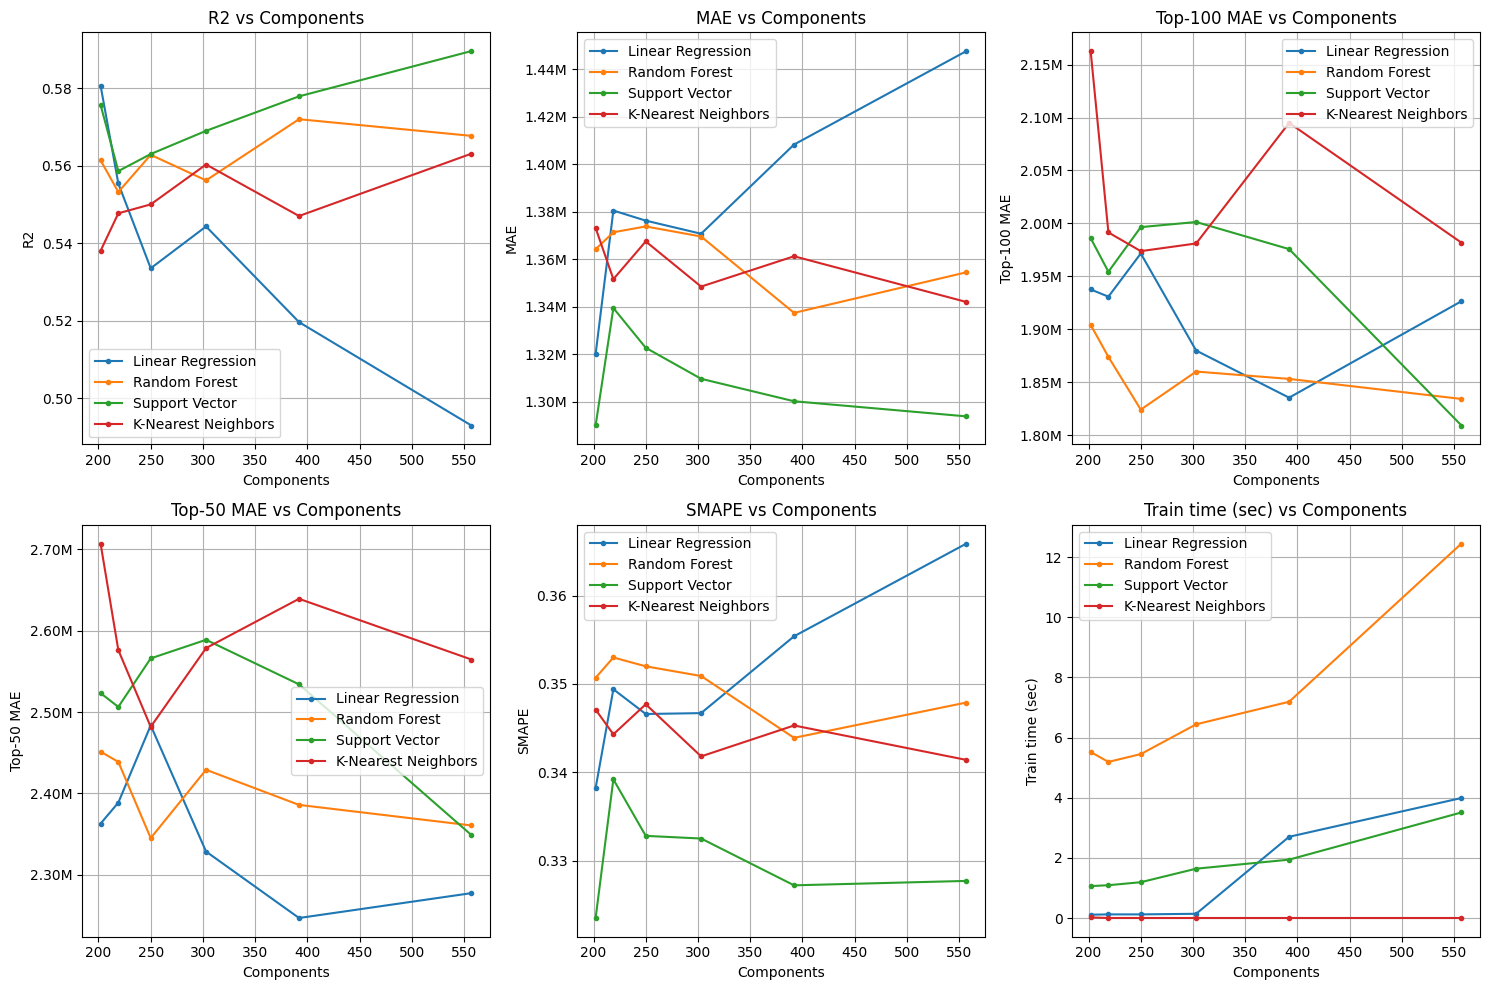

In [11]:
common.plot_metrics(results_df, "Epsilon")
common.plot_metrics(results_df, "Components")

## Sklearn Random Projection

### Gaussian Random Projection

In [12]:
results = []
for eps, n_component in jl_df.to_numpy():
    n_component = int(n_component)

    # Train and test using sklearn
    grp = GaussianRandomProjection(n_components=n_component, eps=eps, random_state=12345)
    X_train_grp = grp.fit_transform(X_train)
    X_test_grp = grp.transform(X_test)
    
    # Train and evaluate the model
    results_df, predictions = common.train_and_evaluate(X_train_grp, y_train, X_test_grp, y_test)

    results_df["Components"] = n_component
    results_df["Epsilon"] = eps

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Epsilon")[results_df.columns].apply(lambda x: x).drop(columns=["Epsilon"])

R2        MAE Top-100 MAE Top-50 MAE   SMAPE  \
Epsilon Model                                                                   
0.4     Linear Regression    0.4192  1,469,078   1,908,124  2,260,402  0.3688   
        Random Forest        0.5620  1,359,857   1,823,444  2,357,254  0.3503   
        Support Vector       0.5801  1,310,526   1,851,573  2,370,715  0.3308   
        K-Nearest Neighbors  0.5510  1,365,011   1,965,775  2,518,604  0.3475   
0.5     Linear Regression    0.5385  1,378,102   1,756,509  2,200,566  0.3490   
        Random Forest        0.5579  1,371,821   1,868,950  2,435,015  0.3526   
        Support Vector       0.5863  1,302,174   1,811,184  2,292,809  0.3271   
        K-Nearest Neighbors  0.5583  1,342,546   1,972,078  2,569,981  0.3415   
0.6     Linear Regression    0.5328  1,410,192   1,754,458  2,214,650  0.3519   
        Random Forest        0.5545  1,376,722   1,800,616  2,329,936  0.3547   
        Support Vector       0.5834  1,310,403   1,848,103  2,344,505  0.3302   
        K-Nearest Neighbors  0.5570  1,338,400   1,984,778  2,527,290  0.3401   
0.7     Linear Regression    0.5434  1,401,641   1,790,909  2,206,982  0.3521   
        Random Forest        0.5626  1,369,404   1,797,362  2,337,838  0.3534   
        Support Vector       0.5817  1,315,331   1,876,547  2,356,015  0.3322   
        K-Nearest Neighbors  0.5619  1,337,662   1,973,702  2,511,175  0.3398   
0.8     Linear Regression    0.5631  1,357,184   1,871,351  2,253,201  0.3454   
        Random Forest        0.5557  1,374,977   1,842,586  2,387,345  0.3531   
        Support Vector       0.5874  1,300,504   1,890,460  2,357,412  0.3292   
        K-Nearest Neighbors  0.5630  1,326,890   1,969,850  2,517,957  0.3374   
0.9     Linear Regression    0.5639  1,349,141   1,911,611  2,290,718  0.3430   
        Random Forest        0.5633  1,358,921   1,811,341  2,349,612  0.3501   
        Support Vector       0.5916  1,290,090   1,873,204  2,330,786  0.3259   
        K-Nearest Neighbors  0.5659  1,324,999   1,946,208  2,472,329  0.3385   

                             Train time (sec)  Components  
Epsilon Model                                              
0.4     Linear Regression                0.24         557  
        Random Forest                    8.96         557  
        Support Vector                   3.13         557  
        K-Nearest Neighbors              0.00         557  
0.5     Linear Regression                0.16         392  
        Random Forest                    7.61         392  
        Support Vector                   1.86         392  
        K-Nearest Neighbors              0.00         392  
0.6     Linear Regression                0.13         303  
        Random Forest                    5.78         303  
        Support Vector                   1.53         303  
        K-Nearest Neighbors              0.00         303  
0.7     Linear Regression                0.12         250  
        Random Forest                    5.24         250  
        Support Vector                   1.12         250  
        K-Nearest Neighbors              0.00         250  
0.8     Linear Regression                0.13         219  
        Random Forest                    5.60         219  
        Support Vector                   1.26         219  
        K-Nearest Neighbors              0.00         219  
0.9     Linear Regression                0.10         202  
        Random Forest                    4.86         202  
        Support Vector                   0.90         202  
        K-Nearest Neighbors              0.00         202

### Sparse Matrix Random Projection

In [13]:
results = []
for eps, n_component in jl_df.to_numpy():
    n_component = int(n_component)

    # Train and test using sklearn
    grp = SparseRandomProjection(n_components=n_component, eps=eps, random_state=12345)
    X_train_grp = grp.fit_transform(X_train)
    X_test_grp = grp.transform(X_test)
    
    # Train and evaluate the models
    results_df, predictions = common.train_and_evaluate(X_train_grp, y_train, X_test_grp, y_test)

    results_df["Components"] = n_component
    results_df["Epsilon"] = eps

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Epsilon")[results_df.columns].apply(lambda x: x).drop(columns=["Epsilon"])

R2        MAE Top-100 MAE Top-50 MAE   SMAPE  \
Epsilon Model                                                                   
0.4     Linear Regression    0.4871  1,441,535   1,938,102  2,303,167  0.3631   
        Random Forest        0.5674  1,351,966   1,803,927  2,346,078  0.3476   
        Support Vector       0.5833  1,301,843   1,899,314  2,430,388  0.3284   
        K-Nearest Neighbors  0.5778  1,337,588   1,943,292  2,448,738  0.3414   
0.5     Linear Regression    0.5162  1,404,633   1,941,664  2,372,015  0.3564   
        Random Forest        0.5524  1,391,693   1,881,728  2,434,763  0.3576   
        Support Vector       0.5772  1,297,153   1,942,015  2,533,461  0.3274   
        K-Nearest Neighbors  0.5454  1,392,000   1,936,565  2,469,002  0.3545   
0.6     Linear Regression    0.5276  1,389,957   1,843,873  2,226,917  0.3523   
        Random Forest        0.5486  1,383,252   1,817,536  2,341,322  0.3536   
        Support Vector       0.5746  1,316,245   1,822,899  2,312,214  0.3318   
        K-Nearest Neighbors  0.5660  1,337,420   1,933,053  2,459,587  0.3393   
0.7     Linear Regression    0.5585  1,343,418   1,642,964  2,032,249  0.3357   
        Random Forest        0.5676  1,364,784   1,855,125  2,355,645  0.3514   
        Support Vector       0.5776  1,290,019   1,855,029  2,430,698  0.3269   
        K-Nearest Neighbors  0.5521  1,370,646   1,997,861  2,510,903  0.3493   
0.8     Linear Regression    0.5793  1,317,984   1,810,111  2,211,133  0.3343   
        Random Forest        0.5530  1,374,642   1,863,367  2,404,346  0.3509   
        Support Vector       0.5862  1,288,950   1,849,318  2,322,432  0.3264   
        K-Nearest Neighbors  0.5789  1,324,909   1,877,110  2,391,925  0.3394   
0.9     Linear Regression    0.5643  1,354,683   1,886,447  2,299,880  0.3399   
        Random Forest        0.5565  1,377,184   1,858,645  2,393,417  0.3521   
        Support Vector       0.5625  1,334,153   1,923,577  2,423,074  0.3363   
        K-Nearest Neighbors  0.5547  1,351,077   1,997,335  2,513,720  0.3448   

                             Train time (sec)  Components  
Epsilon Model                                              
0.4     Linear Regression                0.22         557  
        Random Forest                    8.46         557  
        Support Vector                   3.28         557  
        K-Nearest Neighbors              0.01         557  
0.5     Linear Regression                0.13         392  
        Random Forest                    6.56         392  
        Support Vector                   1.88         392  
        K-Nearest Neighbors              0.00         392  
0.6     Linear Regression                0.12         303  
        Random Forest                    6.89         303  
        Support Vector                   1.48         303  
        K-Nearest Neighbors              0.02         303  
0.7     Linear Regression                0.13         250  
        Random Forest                    5.18         250  
        Support Vector                   1.20         250  
        K-Nearest Neighbors              0.00         250  
0.8     Linear Regression                0.08         219  
        Random Forest                    4.88         219  
        Support Vector                   1.00         219  
        K-Nearest Neighbors              0.00         219  
0.9     Linear Regression                0.10         202  
        Random Forest                    5.05         202  
        Support Vector                   0.99         202  
        K-Nearest Neighbors              0.00         202

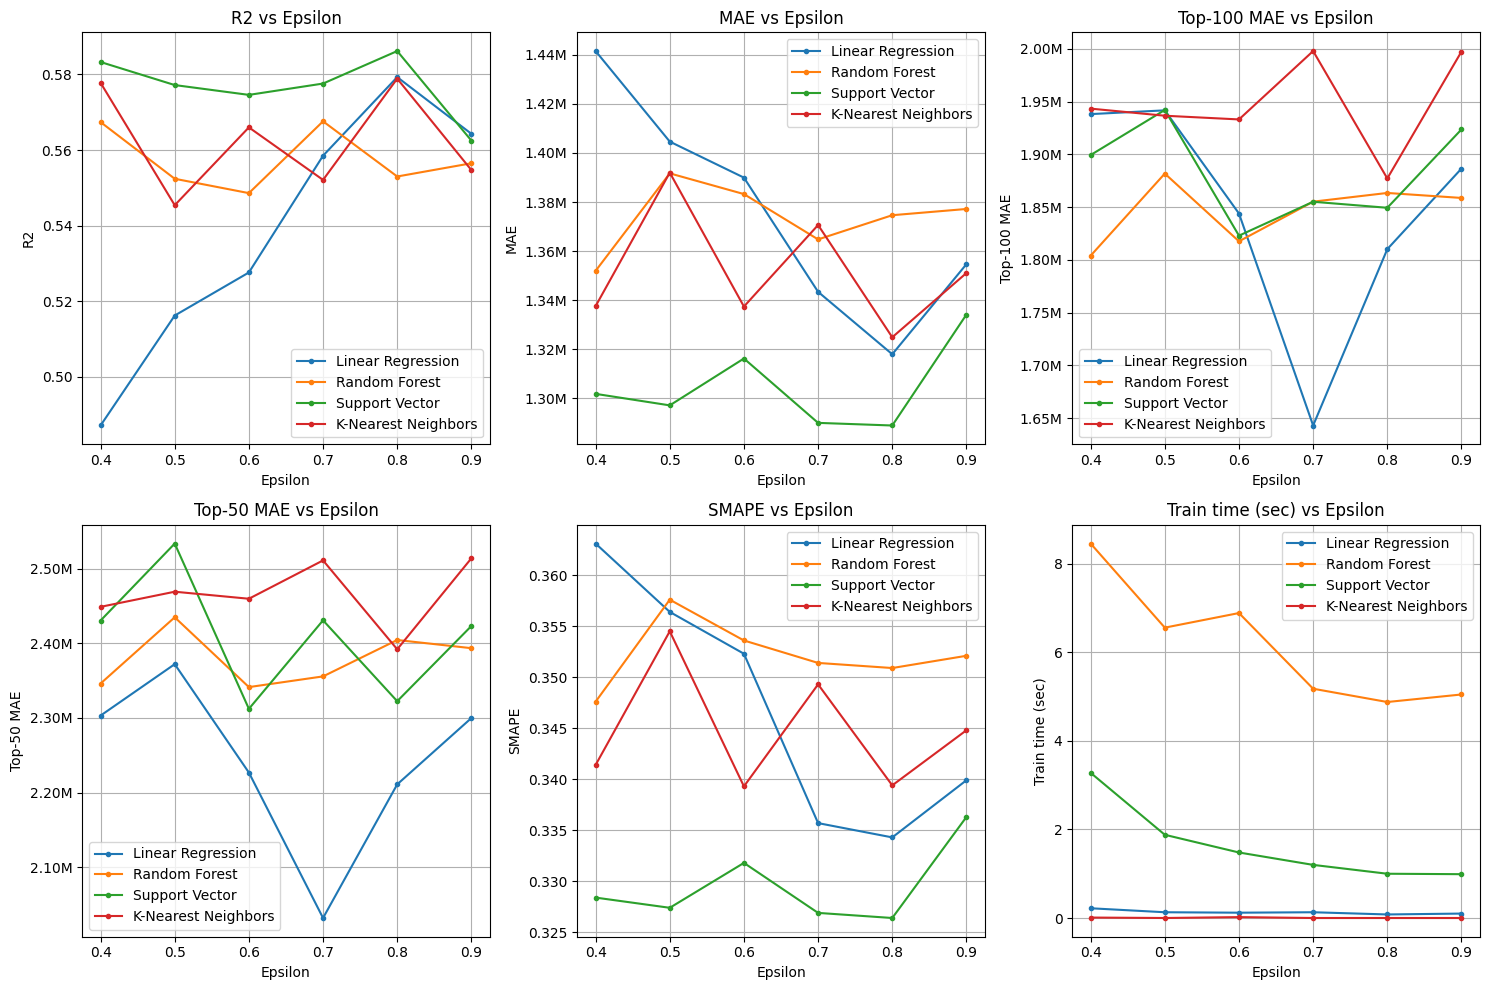

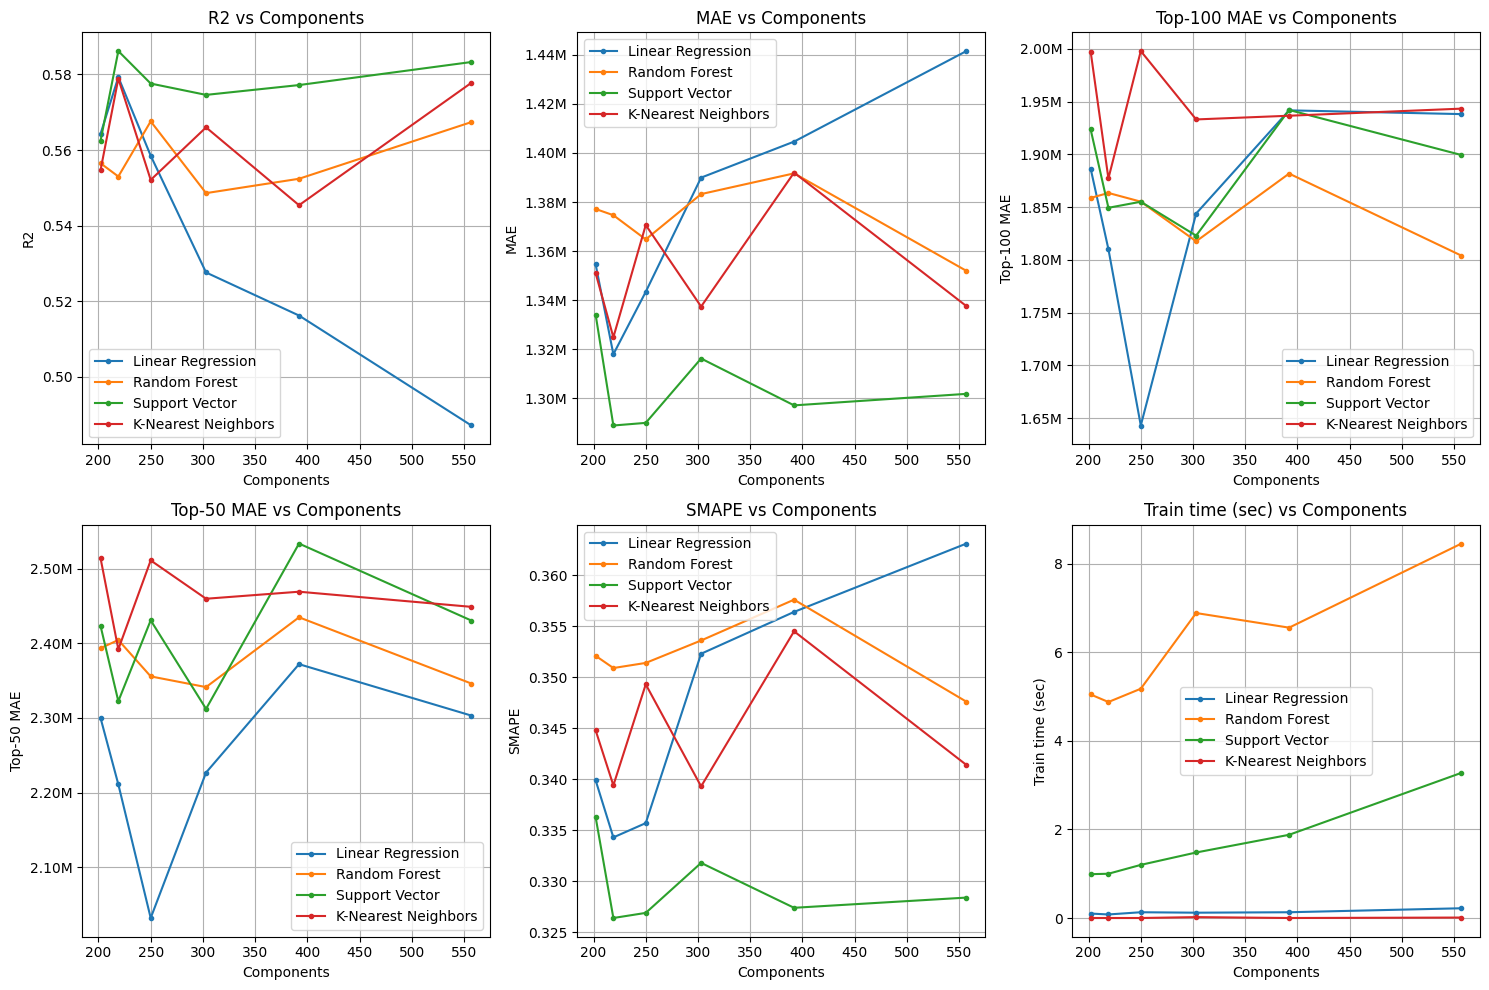

In [14]:
common.plot_metrics(results_df, "Epsilon")
common.plot_metrics(results_df, "Components")